In [10]:
# Getting Started
!uv pip install pynetlogo matplotlib seaborn pandas

# Set the path to your NetLogo installation
# Note! This is OS and machine dependent.
# Perhaps someone has an NL docker image out there?
# See https://pynetlogo.readthedocs.io/en/latest/_docs/pynetlogo.html#pynetlogo.core.NetLogoLink


Using Python 3.12.8 environment at: /Users/peterdresslar/Workspace/cas-520/.venv
Audited 4 packages in 17ms


# Module 2 Assignment: Schelling Segregation Model

*CAS 520, Peter Dresslar*

For this assignment we will use [pynetlogo](https://pynetlogo.readthedocs.io/) to capture and report simulation outputs. An excellent and relevant example appears [here](https://pynetlogo.readthedocs.io/en/latest/_docs/introduction.html)

**Important** pynetlogo will apparently only work reliably with NetLogo 6.3.0. While that presents challenges of its own, it is also important to note the the model we are using, `segregation`, *must* have a version number that matches that version of NetLogo. So, grabbing the latest version of the model may not work without tweaking the file. The model with adjusted version number is in this repository.

`pynetlogo` requires a Java install, for which I used `brew install cask temurin` (on Apple silicon). While the jvm path can be overridden, it appears that pynetlogoʻs implementation of JPype works to automatially find the installed JVM from that cask. Note that I wound up having to point to the `app` directory within the Netlogo base installation.

## Cluster Analysis

I just read (this paper)[https://doi.org/10.1063/5.0115101] and itʻs pretty interesting. Our breakpoint is pretty close to their reported 67 percent.

## Step 1: First Analysis

- Experiment 1: Set density to 80% and similarity wanted to 30% and run the simulation several times.

- Experiment 2: Keeping density at 80%, change the similarity threshold to 90%.

- Experiment 3: While the model is still running from step 2, slowly move the similarity slider to the left and note when the model behaviour changes and segregation emerges.

- Experiment 4: Rerun the simulation a few times with 80% density and similarity threshold at the tipping point you discovered.


We will begin Step 1 by building our experiment harness:

In [11]:
import numpy as np
import pynetlogo
import os
import subprocess
import platform
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd
import json
from datetime import datetime

base_model = "./Segregation.nlogo"  # (copied into this directory!)


def initialize_netlogo():

    ### Some unplesantness for pynetlogo setup:
    # Get Java home (should return ARM Java if that's what's installed)
    java_home = subprocess.check_output(["/usr/libexec/java_home"]).decode().strip()
    jvm_path = os.path.join(java_home, "lib", "server", "libjvm.dylib")
    netlogo_path = "/Users/peterdresslar/Workspace/NetLogo-6.3.0/app"

    # Print for verification
    print(f"Python architecture: {platform.machine()}")
    print(f"Using JVM at: {jvm_path}")
    print(f"Using NetLogo at: {netlogo_path}")

    # Get a netlogo instance
    netlogo = pynetlogo.NetLogoLink(
        gui=False,  # cannot set to true for macs
        netlogo_home=netlogo_path,
        # jvm_path=jvm_path
    )

    return netlogo


def find_breakpoint(netlogo, model, density, precision):
    """
    This is tricky! We start with the given density and similarity wanted.
    We know from manual testing that there is a breakpoint at which point the model
    will reduce to 0% unhappy. We also can observe that this "collapse" occurs within
    1000 ticks, and that the go procedure will halt the model at that point.

    We can run a simple binary "search" to find this point,
    by running the model with similarity-wanted values between 1.0 and 90.0.

    If the model stops within 1000 ticks, we know that the breakpoint is higher than the
    searched similarity-wanted value. If the model runs the full 1000 steps, we know that
    the breakpoint is lower than the searched similarity-wanted value.

    Since we are setting values programatically, we have the luxury of looking beyond the integer values of similarity-wanted.

    args:
        netlogo: the netlogo instance
        model: the model to run

    returns:
        halting_ticks: a list of iteration and the number of ticks it took to halt. no halt = -1
        breakpoint: the similarity-wanted value at which the model breaks down

    """
    STEP_MAX = 1000

    halting_ticks = []
    upper_bound = 100.0  # this is for values of similarity wanted
    lower_bound = 1.0  # not sure how the model would deal with zeroes!
    breakpoint = None

    precision_step = 10 ** (-precision)  # 10e-precision, in other words.

    iteration = 0
    while breakpoint is None:
        iteration += 1
        midpoint = round(
            (upper_bound + lower_bound) / 2, precision
        )  # round to 4 decimal places
        print(f"Iteration {iteration} at {midpoint}")
        netlogo.load_model(model)
        netlogo.command(f"set density {density}")
        netlogo.command(f"set %-similar-wanted {midpoint}")
        netlogo.command("setup")

        netlogo.command("repeat 1000 [go]")
        # we should be able to see if the model halted early by checking the step number

        ticks = netlogo.report("ticks")
        print(f"Ticks: {ticks}")

        halting_ticks.append((iteration, ticks))

        if ticks < STEP_MAX:
            lower_bound = midpoint + precision_step
        else:
            upper_bound = midpoint - precision_step

        if upper_bound - lower_bound < precision_step:
            breakpoint = midpoint

    return (halting_ticks, breakpoint)

def run_breakpoints_scan(netlogo, model, min_density, max_density, step_size, precision):
    breakpoints_data = []

    for density in np.arange(min_density, max_density, step_size):
        print(f"Finding breakpoint for density {density}")
        halting_ticks, breakpoint_value = find_breakpoint(netlogo, model, density=density, precision=precision)
        breakpoints_data.append({
            "density": density,
            "breakpoint": breakpoint_value,
            "ticks_history": halting_ticks  # get all the ticks
        })

    return breakpoints_data


def cluster_analysis(turtle_data):
    """
    Analyze clustering patterns in turtle data from NetLogo.

    Parameters:
    turtle_data - List containing [x_array, y_array, color_array]

    Returns:
    Dictionary of cluster metrics
    """
    results = 1

    return results


def run_experiment(
    netlogo,
    model,
    experiment_name,
    number_of_runs,
    density,
    percent_similar_wanted,
    max_ticks,
):
    """
    Run the model with the given parameters and return the results.

    args:
        netlogo: the netlogo instance
        model: the model to run
        experiment_name: the name of the experiment
        number_of_runs: the number of times to run the model
        density: the density of the model
        similarity_wanted: the similarity wanted of the model
        max_ticks: the maximum number of ticks to run the model

    returns:
        data: a dictionary containing experiment results
        includes:
            - number of runs
            - density
            - similarity wanted
            - average average similarity values
            - average time to happiness, in ticks (or N/A if model never halts)
            - cluster analysis results

    """
    data = {
        "experiment_name": experiment_name,
        "number_of_runs": number_of_runs,
        "density": density,
        "percent_similar_wanted": percent_similar_wanted,
        "average_similarity_values": [],
        "time_to_happiness_values": [],
        "cluster_analysis_values": [],
        "average_average_similarity_values": [],
        "average_time_to_happiness": [],
        "average_cluster_analysis_values": [],
    }

    # collectors
    time_to_happiness_values = []
    average_similarity_values = []
    cluster_analysis_values = []

    for run, _ in enumerate(
        range(number_of_runs), 1
    ):  # is there an easier way to do this? yes! I :heart enumerate.
        print(f"Experiment name {experiment_name}, Run {run} of {number_of_runs}")

        netlogo.load_model(model)

        netlogo.command(f"set density {density}")
        netlogo.command(f"set %-similar-wanted {percent_similar_wanted}")
        netlogo.command("setup")

        # run the model. it will halt from inside netlogo if it meets the stopping condition (no unhappy turtles)
        netlogo.command(f"repeat {max_ticks} [go]")

        ticks = netlogo.report("ticks")
        if (
            ticks < max_ticks
        ):  # we will assume that the model did not achieve happiness on the very last tick!
            run_time_to_happiness = ticks
        else:
            run_time_to_happiness = None

        run_average_similarity = netlogo.report("percent-similar")

        # grab the turtle data for cluster analysis
        # this is almost word for word from the pynetlogo introduction, cell 6
        x = netlogo.report("map [t -> [xcor] of t] sort turtles")
        y = netlogo.report("map [t -> [ycor] of t] sort turtles")
        turtle_color = netlogo.report("map [t -> [color] of t] sort turtles")
        turtle_happiness = netlogo.report("map [t -> [happy?] of t] sort turtles")
        turtle_data = [x, y, turtle_color, turtle_happiness]

        print(turtle_data)
        run_cluster_analysis = cluster_analysis(turtle_data)  # need to write function

        ticks_print = ticks if ticks else "N/A"  # donʻt break the print statement
        print(
            f" Run {run} complete, ticks: {ticks_print}, average similarity: {run_average_similarity}, cluster analysis: {run_cluster_analysis}"
        )

        # store to collectors
        time_to_happiness_values.append(run_time_to_happiness)
        average_similarity_values.append(run_average_similarity)
        cluster_analysis_values.append(run_cluster_analysis)

    # move collectors to data
    data["time_to_happiness_values"] = time_to_happiness_values
    data["average_similarity_values"] = average_similarity_values
    data["cluster_analysis_values"] = cluster_analysis_values

    # letʻs do some post-processing
    data["average_time_to_happiness"] = sum(time_to_happiness_values) / len(
        time_to_happiness_values
    )
    data["average_average_similarity_values"] = sum(average_similarity_values) / len(
        average_similarity_values
    )
    # data["average_cluster_analysis_values"] = sum(cluster_analysis_values) / len(cluster_analysis_values) if cluster_analysis_values else 0

    print(
        f"Experiment {experiment_name} complete, average time to happiness: {data['average_time_to_happiness']}, average average similarity: {data['average_average_similarity_values']}, average cluster analysis: {data['average_cluster_analysis_values']}"
    )

    return data

# Create DataFrame from existing breakpoints data
def get_df(breakpoints_data):
    densities = list(np.arange(min_density, max_density, step_size))   # todo this line is odd
    breakpoints_df = pd.DataFrame(breakpoints_data)
    return breakpoints_df

# Modified plotting function to show both relationships
def plot_density_relationships(df):
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 10))
    
    # First subplot - Breakpoints
    ax1.plot(df['density'], df['breakpoint'], 'b.-')
    ax1.axhline(y=75, color='r', linestyle='--', label='75% Threshold')
    ax1.grid(True)
    ax1.set_xlabel('Population Density (%)')
    ax1.set_ylabel('Critical Similarity Threshold (%)')
    ax1.set_title('Critical Similarity Threshold vs Population Density')
    ax1.legend()

    # Second subplot - Time to happiness
    final_ticks = [history[-1][1] for history in df['ticks_history']]
    ax2.plot(df['density'], final_ticks, 'g.-')
    ax2.grid(True)
    ax2.set_xlabel('Population Density (%)')
    ax2.set_ylabel('Ticks to Happiness')
    ax2.set_title('Time to Happiness at Critical Threshold')

    plt.tight_layout()
    plt.show()

def plot_3d_convergence(json_data):
    fig = plt.figure(figsize=(15, 10))
    ax = fig.add_subplot(111, projection='3d')

    # Create a different color for each density value
    colors = plt.cm.viridis(np.linspace(0, 1, len(json_data)))
    
    for data_point, color in zip(json_data, colors):
        density = data_point['density']
        iterations, ticks = zip(*data_point['ticks_history'])
        densities = [density] * len(iterations)
        
        # Plot with color and add some transparency
        ax.plot(densities, iterations, ticks, color=color, alpha=0.6, linewidth=2)

    ax.view_init(elev=20, azim=45)  # Adjust viewing angle
    ax.set_xlabel('Population Density (%)')
    ax.set_ylabel('Iteration')
    ax.set_zlabel('Ticks to Happiness')
    ax.set_title('Convergence Paths to Critical Thresholds')

    plt.show()


We are almost ready to run our experiments, but before we do that, we have a great opportunity to scan for phase transition points, not just at density 80, but at all densities.

In [12]:


min_density = 50
max_density = 100
step_size = 1
precision = 2

netlogo = initialize_netlogo()

breakpoints_data = run_breakpoints_scan(netlogo, base_model, min_density, max_density, step_size, precision)

# Convert any numpy types to native Python types for JSON serialization
json_data = []
for item in breakpoints_data:
    json_data.append({
        "density": float(item["density"]),
        "breakpoint": float(item["breakpoint"]),
        "ticks_history": [[int(iter_num), float(ticks)] for iter_num, ticks in item["ticks_history"]]  # Convert each pair
    })

print(f"Found {len(breakpoints_data)} breakpoints.")




Python architecture: arm64
Using JVM at: /Library/Java/JavaVirtualMachines/temurin-24.jdk/Contents/Home/lib/server/libjvm.dylib
Using NetLogo at: /Users/peterdresslar/Workspace/NetLogo-6.3.0/app
Finding breakpoint for density 50
Iteration 1 at 50.5


/Users/peterdresslar/Workspace/cas-520/.venv/lib/python3.12/site-packages/pynetlogo/core.py:209: UserWarning: could not find default NetLogo extensions folder. Extensions not available
  warnings.warn(


Ticks: 24.0
Iteration 2 at 75.25
Ticks: 414.0
Iteration 3 at 87.63
Ticks: 1000.0
Iteration 4 at 81.44
Ticks: 1000.0
Iteration 5 at 78.34
Ticks: 536.0
Iteration 6 at 79.89
Ticks: 435.0
Iteration 7 at 80.66
Ticks: 1000.0
Iteration 8 at 80.28
Ticks: 1000.0
Iteration 9 at 80.09
Ticks: 1000.0
Iteration 10 at 79.99
Ticks: 597.0
Iteration 11 at 80.04
Ticks: 1000.0
Iteration 12 at 80.02
Ticks: 1000.0
Finding breakpoint for density 51
Iteration 1 at 50.5
Ticks: 24.0
Iteration 2 at 75.25
Ticks: 525.0
Iteration 3 at 87.63
Ticks: 1000.0
Iteration 4 at 81.44
Ticks: 1000.0
Iteration 5 at 78.34
Ticks: 362.0
Iteration 6 at 79.89
Ticks: 705.0
Iteration 7 at 80.66
Ticks: 1000.0
Iteration 8 at 80.28
Ticks: 1000.0
Iteration 9 at 80.09
Ticks: 1000.0
Iteration 10 at 79.99
Ticks: 459.0
Iteration 11 at 80.04
Ticks: 1000.0
Iteration 12 at 80.02
Ticks: 1000.0
Finding breakpoint for density 52
Iteration 1 at 50.5
Ticks: 28.0
Iteration 2 at 75.25
Ticks: 576.0
Iteration 3 at 87.63
Ticks: 1000.0
Iteration 4 at 81.4

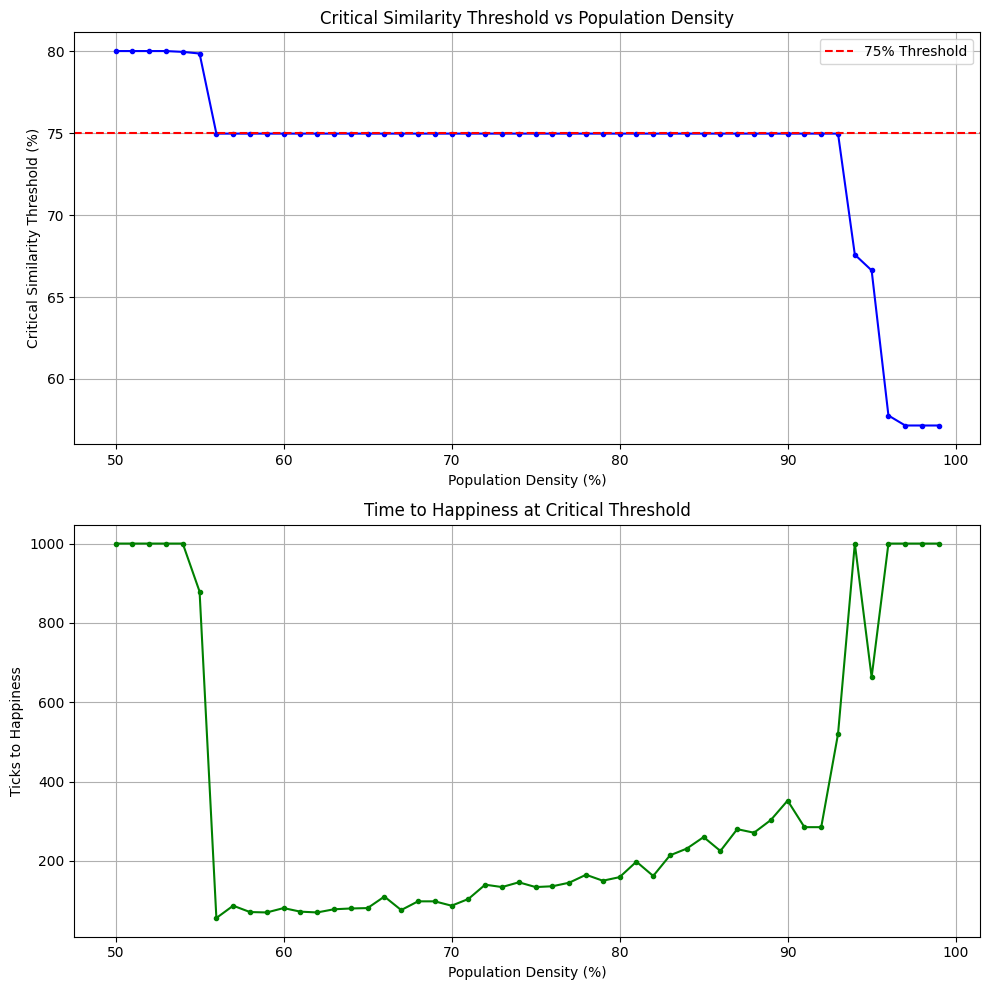

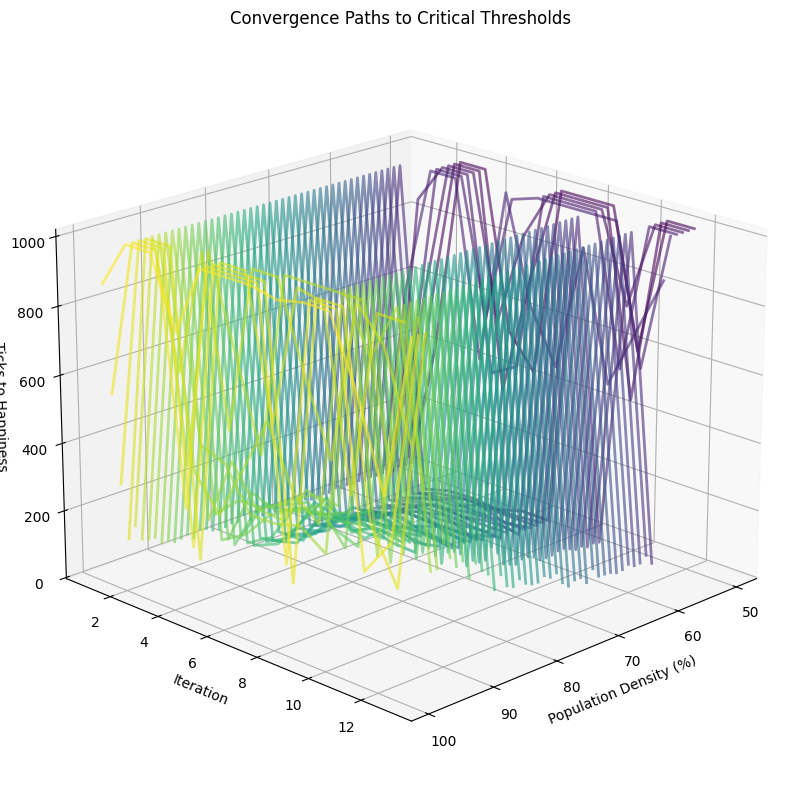

Data saved to data/breakpoints_data_20250324_150226.json


In [13]:
breakpoints_df = get_df(breakpoints_data)

# Plot both relationships
plot_density_relationships(breakpoints_df)

# plot the 3d ticks history
plot_3d_convergence(json_data)

# First, let's add a timestamp to the filename to keep multiple runs
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
filename = f'data/breakpoints_data_{timestamp}.json'

# finally, write the breakpoints data to a json file
with open(filename, 'w') as f:
    json.dump(json_data, f, indent=2)  # indent=2 makes it human-readable

print(f"Data saved to {filename}")

breakpoints_data.clear()  # explicit cleanup
del breakpoints_df



In [14]:
min_density = 50
max_density = 60
step_size = .1
precision = 2

# clean up JVM memory from netlogo and start fresh
netlogo.kill_workspace()
netlogo = initialize_netlogo()

breakpoints_data_low_band = run_breakpoints_scan(netlogo, base_model, min_density, max_density, step_size, precision)

timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
low_band_filename = f'data/breakpoints_data_low_band_{timestamp}.json'

json_data_low_band = []
for item in breakpoints_data_low_band:
    json_data_low_band.append({
        "density": float(item["density"]),
        "breakpoint": float(item["breakpoint"]),
        "ticks_history": [[int(iter_num), float(ticks)] for iter_num, ticks in item["ticks_history"]]  # Convert each pair
    })

print(f"Found {len(breakpoints_data_low_band)} breakpoints.")


Python architecture: arm64
Using JVM at: /Library/Java/JavaVirtualMachines/temurin-24.jdk/Contents/Home/lib/server/libjvm.dylib
Using NetLogo at: /Users/peterdresslar/Workspace/NetLogo-6.3.0/app
Finding breakpoint for density 50.0
Iteration 1 at 50.5
Ticks: 24.0
Iteration 2 at 75.25
Ticks: 389.0
Iteration 3 at 87.63
Ticks: 1000.0
Iteration 4 at 81.44
Ticks: 1000.0
Iteration 5 at 78.34
Ticks: 488.0
Iteration 6 at 79.89
Ticks: 353.0
Iteration 7 at 80.66
Ticks: 1000.0
Iteration 8 at 80.28
Ticks: 1000.0
Iteration 9 at 80.09
Ticks: 1000.0
Iteration 10 at 79.99
Ticks: 307.0
Iteration 11 at 80.04
Ticks: 1000.0
Iteration 12 at 80.02
Ticks: 1000.0
Finding breakpoint for density 50.1
Iteration 1 at 50.5
Ticks: 35.0
Iteration 2 at 75.25
Ticks: 438.0
Iteration 3 at 87.63
Ticks: 1000.0
Iteration 4 at 81.44
Ticks: 1000.0
Iteration 5 at 78.34
Ticks: 967.0
Iteration 6 at 79.89
Ticks: 424.0
Iteration 7 at 80.66
Ticks: 1000.0
Iteration 8 at 80.28
Ticks: 1000.0
Iteration 9 at 80.09
Ticks: 1000.0
Iteratio

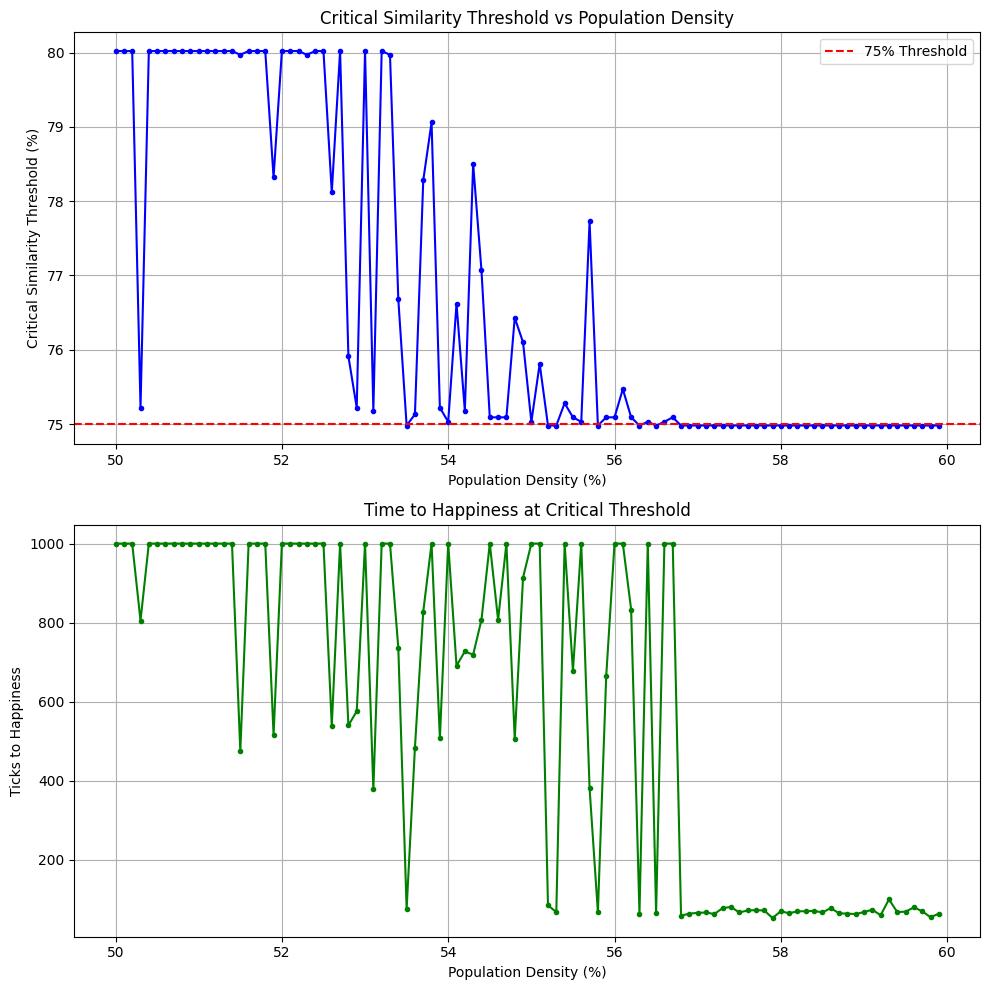

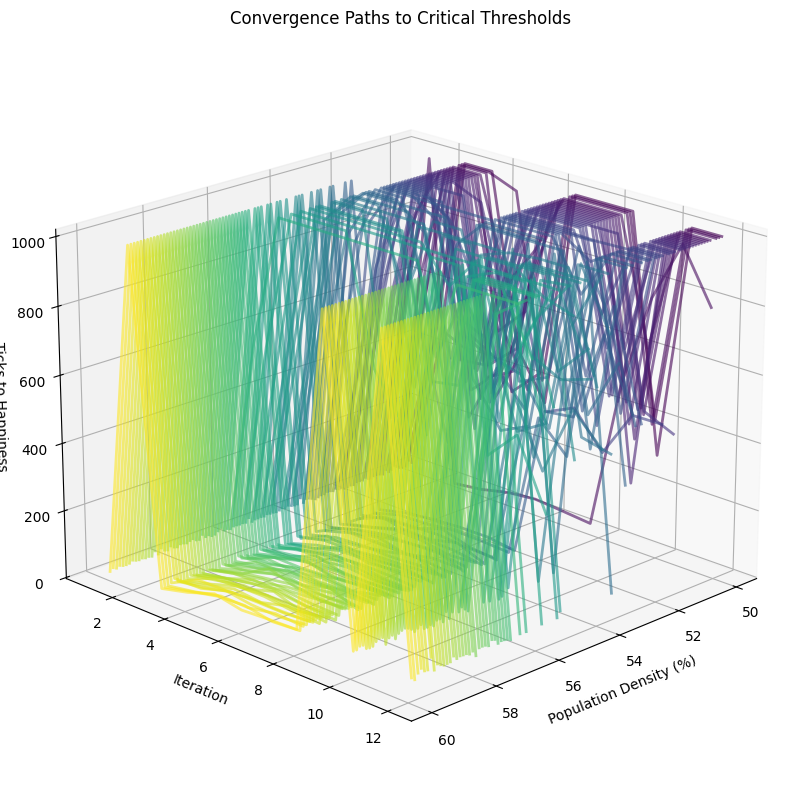

Data saved to data/breakpoints_data_low_band_20250324_153055.json


In [15]:
breakpoints_df_low_band = get_df(breakpoints_data_low_band)

plot_density_relationships(breakpoints_df_low_band)
plot_3d_convergence(json_data_low_band)

# finally, write the breakpoints data to a json file
with open(low_band_filename, 'w') as f:
    json.dump(json_data_low_band, f, indent=2)  # indent=2 makes it human-readable

print(f"Data saved to {low_band_filename}")

breakpoints_data_low_band.clear()  # explicit cleanup
del breakpoints_df_low_band



In [ ]:
min_density = 90
max_density = 99
step_size = .1
precision = 2

# clean up JVM memory from netlogo and start fresh 
netlogo.kill_workspace()
netlogo = initialize_netlogo()

breakpoints_data_high_band = run_breakpoints_scan(netlogo, base_model, min_density, max_density, step_size, precision)

# First, let's add a timestamp to the filename to keep multiple runs
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
high_band_filename = f'data/breakpoints_data_high_band_{timestamp}.json'

# Convert any numpy types to native Python types for JSON serialization
json_data_high_band = []
for item in breakpoints_data_high_band:
    json_data_high_band.append({
        "density": float(item["density"]),
        "breakpoint": float(item["breakpoint"]),
        "ticks_history": [[int(iter_num), float(ticks)] for iter_num, ticks in item["ticks_history"]]  # Convert each pair
    })

print(f"Found {len(breakpoints_data_high_band)} breakpoints.")

Python architecture: arm64
Using JVM at: /Library/Java/JavaVirtualMachines/temurin-24.jdk/Contents/Home/lib/server/libjvm.dylib
Using NetLogo at: /Users/peterdresslar/Workspace/NetLogo-6.3.0/app
Finding breakpoint for density 90.0
Iteration 1 at 50.5
Ticks: 46.0
Iteration 2 at 75.25
Ticks: 1000.0
Iteration 3 at 62.88
Ticks: 132.0
Iteration 4 at 69.06
Ticks: 309.0
Iteration 5 at 72.16
Ticks: 265.0
Iteration 6 at 73.7
Ticks: 285.0
Iteration 7 at 74.47
Ticks: 344.0
Iteration 8 at 74.86
Ticks: 270.0
Iteration 9 at 75.06
Ticks: 1000.0
Iteration 10 at 74.96
Ticks: 318.0
Iteration 11 at 75.01
Ticks: 1000.0
Iteration 12 at 74.98
Ticks: 336.0
Finding breakpoint for density 90.1
Iteration 1 at 50.5
Ticks: 51.0
Iteration 2 at 75.25
Ticks: 1000.0
Iteration 3 at 62.88
Ticks: 141.0
Iteration 4 at 69.06
Ticks: 317.0
Iteration 5 at 72.16
Ticks: 470.0
Iteration 6 at 73.7
Ticks: 253.0
Iteration 7 at 74.47
Ticks: 467.0
Iteration 8 at 74.86
Ticks: 328.0
Iteration 9 at 75.06
Ticks: 1000.0
Iteration 10 at 7

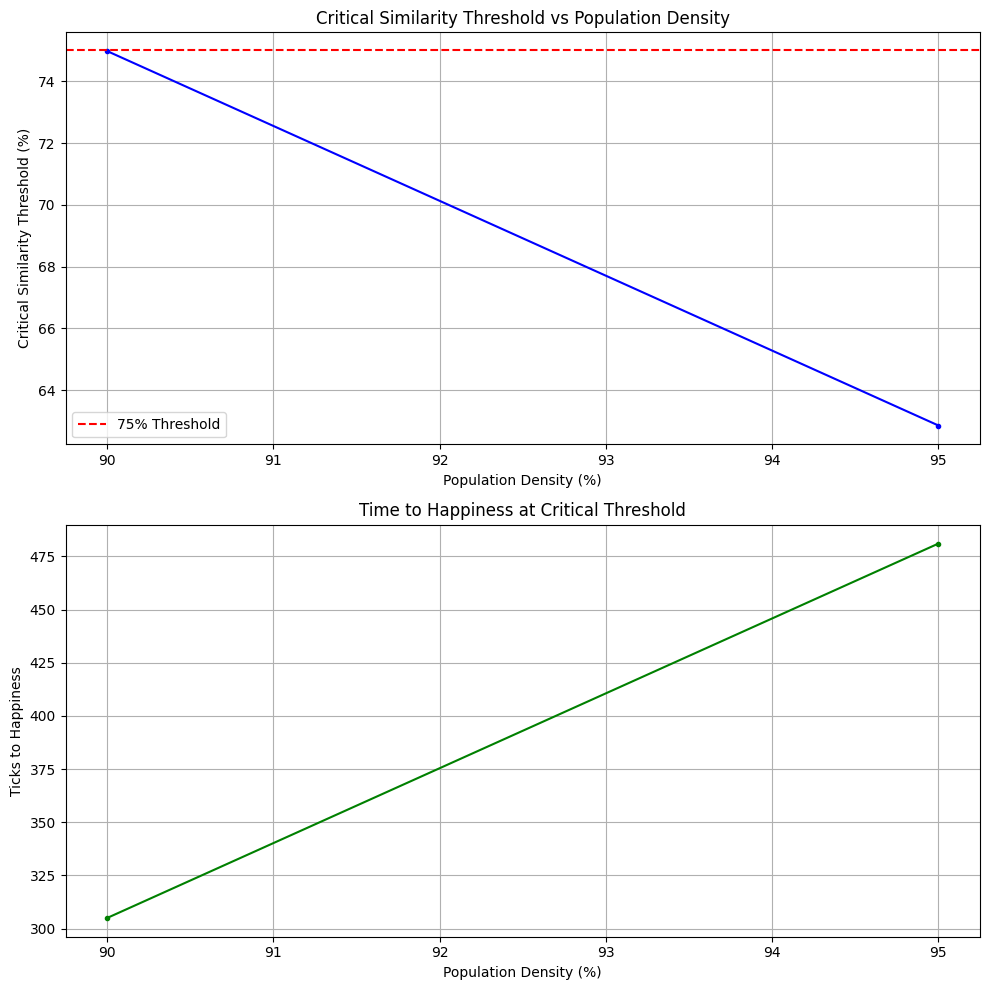

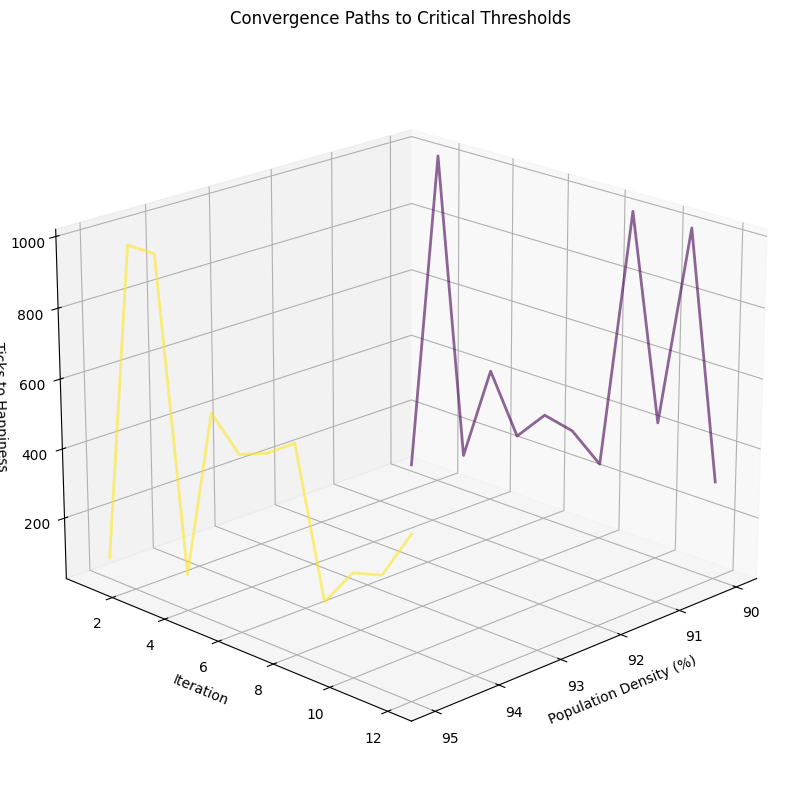

Data saved to data/breakpoints_data_high_band_20250324_143314.json


In [8]:

breakpoints_df_high_band = get_df(breakpoints_data_high_band)

plot_density_relationships(breakpoints_df_high_band)
plot_3d_convergence(json_data_high_band)

with open(high_band_filename, 'w') as f:
    json.dump(json_data_high_band, f, indent=2)  # indent=2 makes it human-readable

print(f"Data saved to {high_band_filename}")

breakpoints_data_high_band.clear()  # explicit cleanup
del breakpoints_df_high_band


Note! An interesting phenomenon at these values:

```
Finding breakpoint for density 99.09999999999948
Iteration 1 at 50.5
Ticks: 1000.0
Iteration 2 at 25.75
```

Iteration 2 hangs!

Letʻs look at the previous two iterations, which of course see-saw across the phase transition:

```
Finding breakpoint for density 98.8999999999995
Iteration 1 at 50.5
Ticks: 1000.0
Iteration 2 at 25.75
Ticks: 14.0
Iteration 3 at 38.12
Ticks: 29.0
Iteration 4 at 44.31
Ticks: 1000.0
Iteration 5 at 41.22
Ticks: 34.0
Iteration 6 at 42.77
Ticks: 33.0
Iteration 7 at 43.54
Ticks: 1000.0
Iteration 8 at 43.16
Ticks: 1000.0
Iteration 9 at 42.97
Ticks: 1000.0
Iteration 10 at 42.87
Ticks: 31.0
Iteration 11 at 42.92
Ticks: 27.0
Iteration 12 at 42.95
Ticks: 29.0
Finding breakpoint for density 98.99999999999949
Iteration 1 at 50.5
Ticks: 1000.0
Iteration 2 at 25.75
Ticks: 21.0
Iteration 3 at 38.12
Ticks: 66.0
Iteration 4 at 44.31
Ticks: 1000.0
Iteration 5 at 41.22
Ticks: 34.0
Iteration 6 at 42.77
Ticks: 31.0
Iteration 7 at 43.54
Ticks: 44.0
Iteration 8 at 43.92
Ticks: 26.0
Iteration 9 at 44.12
Ticks: 30.0
Iteration 10 at 44.22
Ticks: 1000.0
Iteration 11 at 44.17
Ticks: 1000.0
Iteration 12 at 44.14
Ticks: 45.0
Iteration 13 at 44.16
Ticks: 27.0
```

so, we can guess that iteation two might collapse into the static state *very* rapidly.


In [1]:
netlogo.kill_workspace()
netlogo = initialize_netlogo()

experiment_1 = run_experiment(netlogo, base_model, experiment_name="Experiment 1", number_of_runs=2, density=80, percent_similar_wanted=30, max_ticks=1000)

NameError: name 'netlogo' is not defined